<a href="https://colab.research.google.com/github/Ahmed-M-Elshazly/Homework-7/blob/main/Homework_7_Problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Homework 2
#Problem3_cifar10_Resnet11
#Ahmed Elshazly
#801420724

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, f1_score
import time
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F

In [ ]:
# Set device
device1 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load CIFAR-10 dataset to calculate mean and std
train_dataset = torchvision.datasets.CIFAR10('../data-unversioned/p1ch7/', train=True, download=True)
val_dataset = torchvision.datasets.CIFAR10('../data-unversioned/p1ch7/', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
img, label = train_dataset[100]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 8, 'ship')

In [ ]:
len(train_dataset)

50000

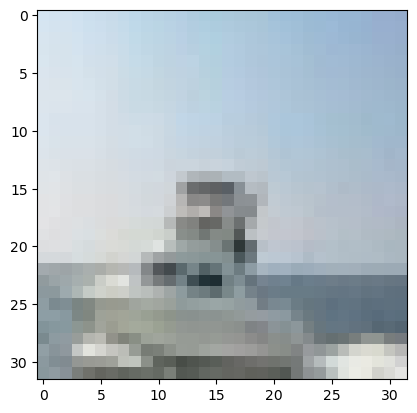

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
from torchvision import transforms

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [ ]:
train_dataset = torchvision.datasets.CIFAR10('../data-unversioned/p1ch7/', train=True, download=False,
                          transform=transforms.ToTensor())
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

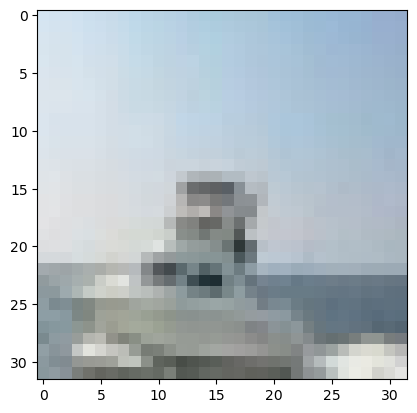

In [ ]:
plt.imshow(img_t.permute(1, 2, 0))  # <1>
plt.show()

In [ ]:
train_mean=imgs.view(3, -1).mean(dim=1)
train_std=imgs.view(3, -1).std(dim=1)
print(train_mean)
print(train_std)


tensor([0.4914, 0.4822, 0.4465])
tensor([0.2470, 0.2435, 0.2616])


In [ ]:
transforms.Normalize(train_mean, train_std)


Normalize(mean=tensor([0.4914, 0.4822, 0.4465]), std=tensor([0.2470, 0.2435, 0.2616]))

In [ ]:
transformed_train_dataset = torchvision.datasets.CIFAR10(
    '../data-unversioned/p1ch7/', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(train_mean,
                             train_std)
    ]))
train_loader = torch.utils.data.DataLoader(transformed_train_dataset, batch_size=128, shuffle=True)

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)


        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)


        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):

        out = F.relu(self.bn1(self.conv1(x)))

        out = self.bn2(self.conv2(out))

        out += self.shortcut(x)

        out = F.relu(out)
        return out

class ResNet11(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet11, self).__init__()
        self.in_channels = 64


        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)


        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=1)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=1)


        self.linear = nn.Linear(512 * 4*4, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):

        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):

        out=F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out




model = ResNet11(BasicBlock, [1, 1, 1, 1], num_classes=10).to(device1)

In [ ]:
val_dataset = torchvision.datasets.CIFAR10('../data-unversioned/p1ch7/', train=False, download=False,
                          transform=transforms.ToTensor())

In [ ]:
imgs = torch.stack([img_t for img_t, _ in val_dataset], dim=3)
imgs.shape

torch.Size([3, 32, 32, 10000])

In [ ]:
val_mean=imgs.view(3, -1).mean(dim=1)
val_std=imgs.view(3, -1).std(dim=1)
print(val_mean)
print(val_std)


tensor([0.4942, 0.4851, 0.4504])
tensor([0.2467, 0.2429, 0.2616])


In [ ]:
transforms.Normalize(val_mean, val_std)

Normalize(mean=tensor([0.4942, 0.4851, 0.4504]), std=tensor([0.2467, 0.2429, 0.2616]))

In [ ]:
transformed_val_dataset = torchvision.datasets.CIFAR10(
    '../data-unversioned/p1ch7/', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(train_mean,
                             train_std)
    ]))
val_loader = torch.utils.data.DataLoader(transformed_val_dataset, batch_size=128, shuffle=False)

Epoch: 1, Train Loss: 1.511367, Val_Loss:1.111107, Runtime: 33.00 seconds, Train Accurracy : 0.581280, Validation Accuracy : 0.601900
Epoch: 2, Train Loss: 1.018660, Val_Loss:0.982427, Runtime: 32.57 seconds, Train Accurracy : 0.670120, Validation Accuracy : 0.631550
Epoch: 3, Train Loss: 0.825052, Val_Loss:0.811207, Runtime: 32.91 seconds, Train Accurracy : 0.724800, Validation Accuracy : 0.660867
Epoch: 4, Train Loss: 0.709403, Val_Loss:0.871365, Runtime: 32.66 seconds, Train Accurracy : 0.762820, Validation Accuracy : 0.672400
Epoch: 5, Train Loss: 0.618840, Val_Loss:0.835826, Runtime: 32.53 seconds, Train Accurracy : 0.791948, Validation Accuracy : 0.680320
Epoch: 6, Train Loss: 0.548610, Val_Loss:0.755770, Runtime: 32.62 seconds, Train Accurracy : 0.815820, Validation Accuracy : 0.690033
Epoch: 7, Train Loss: 0.484526, Val_Loss:0.700362, Runtime: 32.71 seconds, Train Accurracy : 0.835374, Validation Accuracy : 0.699957
Epoch: 8, Train Loss: 0.419620, Val_Loss:0.682323, Runtime: 32

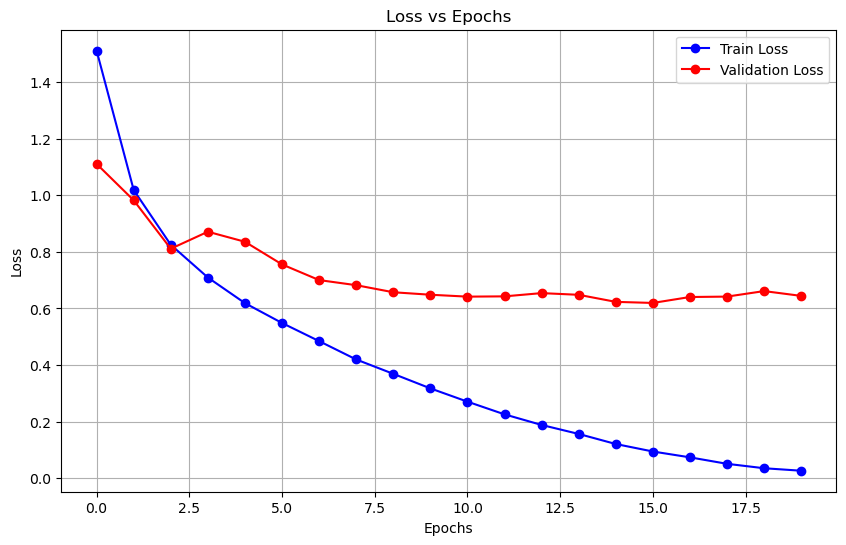

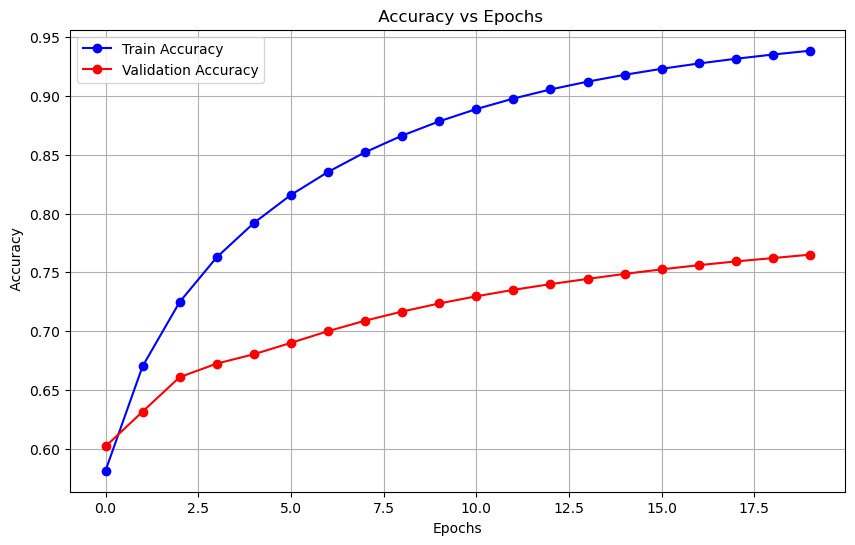

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_epochs = 20
total_start_time = time.time()
losses=[]
val_losses=[]
train_accs=[]
val_accs=[]
tr_correct=0
tr_total=0
val_correct=0
val_total=0

for epoch in range(num_epochs):
    start_time = time.time()
    counter=0
    cum_loss=0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device1), labels.to(device1)
        batch_size=imgs.shape[0]
        outputs=model(imgs)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        outputs=model(imgs)
        _,predicted=torch.max(outputs,dim=1)
        tr_total+=labels.shape[0]
        tr_correct+=int((predicted==labels).sum())
        counter+=1
        cum_loss+=loss

    tr_acc=tr_correct/tr_total
    epoch_loss=cum_loss/counter

    counter_val=0
    cum_loss_val=0
    for imgs, labels in val_loader:
      imgs, labels = imgs.to(device1), labels.to(device1)
      batch_size=imgs.shape[0]
      with torch.no_grad():
        outputs = model(imgs)
        val_loss = loss_fn(outputs, labels)
      _,predicted=torch.max(outputs,dim=1)
      val_total+=labels.shape[0]
      val_correct+=int((predicted==labels).sum())
      counter_val+=1
      cum_loss_val+=val_loss

    val_acc=val_correct/val_total
    epoch_val_loss=cum_loss_val/counter_val



    end_time = time.time()
    training_time = end_time - start_time
    print(f"Epoch: {epoch+1}, Train Loss: {float(epoch_loss):.6f}, Val_Loss:{float(epoch_val_loss):.6f}, Runtime: {training_time:.2f} seconds, Train Accurracy : {float(tr_acc):.6f}, Validation Accuracy : {float(val_acc):.6f}")
    losses.append(float(epoch_loss))
    val_losses.append(float(epoch_val_loss))
    train_accs.append(float(tr_acc))
    val_accs.append(float(val_acc))

total_end_time = time.time()
total_training_time = total_end_time - total_start_time
print(f'Total Training Time: {total_training_time:.2f} seconds')
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), losses, marker='o', linestyle='-', color='b',label='Train Loss')
plt.plot(range(num_epochs), val_losses, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


# Plotting train accur vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_accs, marker='o', linestyle='-', color='b',label='Train Accuracy')
plt.plot(range(num_epochs), val_accs, marker='o', linestyle='-', color='r',label='Validation Accuracy')
plt.title(" Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel(" Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def get_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

In [ ]:
total_params, trainable_params = get_model_size(model)
print(f"  Total parameters: {total_params}")
print(f"  Trainable parameters: {trainable_params}")

  Total parameters: 4987722
  Trainable parameters: 4987722


In [ ]:
torch.save(model, "saved_model.pth")
print("Full model saved as 'saved_model.pth'")


torch.save(model.state_dict(), "saved_weights.pth")
print("Model weights saved as 'saved_weights.pth'")

Full model saved as 'saved_model.pth'
Model weights saved as 'saved_weights.pth'
